# Detecting Counterfeit Bills with Machine Learning
## Cyril Gorlla
### University of California, San Diego

## Introduction

We will examine the Swiss bank notes dataset. The dataset contains six variables measured on 100 genuine and 100 counterfeit
old Swiss 1000-franc bank notes:

1. Length of the note
2. Width of the Left-Hand side of the note
3. Width of the Right-Hand side of the note
4. Width of the Bottom Margin
5. Width of the Top Margin
6. Diagonal Length of Printed Area

We wish to utilize supervised machine learning to see if it is possible to predict whether or not a particular note is genuine or counterfeit. We will divide the data into training and validation sets and implement $K$-fold cross validation. We will then evaluate the performance of various classifiers before and after dimensionality reduction.

*Certain statistical code courtesy Tucker McElroy.*

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f4/CHF_Banknotes.jpg">
<a href="https://commons.wikimedia.org/wiki/File:CHF_Banknotes.jpg">MadGeographer</a>, Public domain, via Wikimedia Commons

In [ ]:
library(Hmisc)
library(caret)
library(lattice)
library(ellipse)
library(scatterplot3d)
library(pracma)

In [80]:
set.seed(123) #Set seed to ensure same splitting

In [2]:
notes = read.table('SBN.txt')
head(notes)

,Length,Left,Right,Bottom,Top,Diagonal
BN1,214.8,131.0,131.1,9.0,9.7,141.0
BN2,214.6,129.7,129.7,8.1,9.5,141.7
BN3,214.8,129.7,129.7,8.7,9.6,142.2
BN4,214.8,129.7,129.6,7.5,10.4,142.0
BN5,215.0,129.6,129.7,10.4,7.7,141.8
BN6,215.7,130.8,130.5,9.0,10.1,141.4


*Source*: [GitHub](https://github.com/tuckermcelroy/ma189/blob/main/Data/SBN.txt)

Flury, B. and Riedwyl, H. (1988). *Multivariate Statistics: A practical approach*. London: Chapman & Hall, Tables 1.1 and 1.2, pp. 5-8.

BN1-100 are genuine, while 101-200 are counterfeit. Let's explore these two groups together and separately.

In [3]:
colMeans(notes)

Length     Left    Right   Bottom      Top Diagonal 
214.8960 130.1215 129.9565   9.4175  10.6505 140.4835

In [4]:
genuine = notes[1:100,]
colMeans(genuine)

Length     Left    Right   Bottom      Top Diagonal 
 214.969  129.943  129.720    8.305   10.168  141.517

In [5]:
counterfeit =  notes[101:200,]
colMeans(counterfeit)

Length     Left    Right   Bottom      Top Diagonal 
 214.823  130.300  130.193   10.530   11.133  139.450

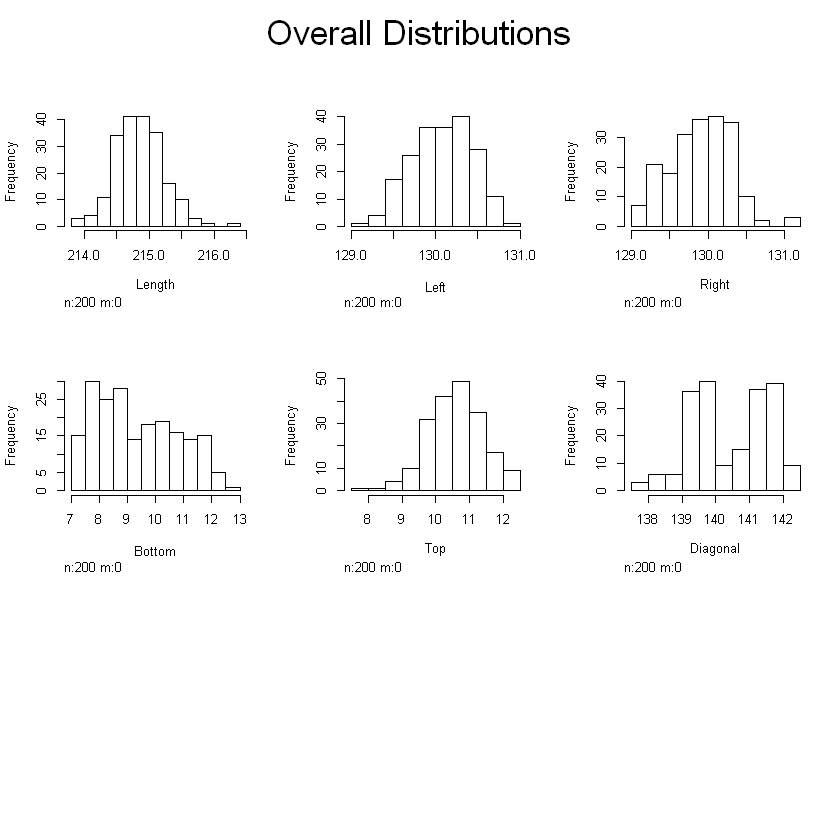

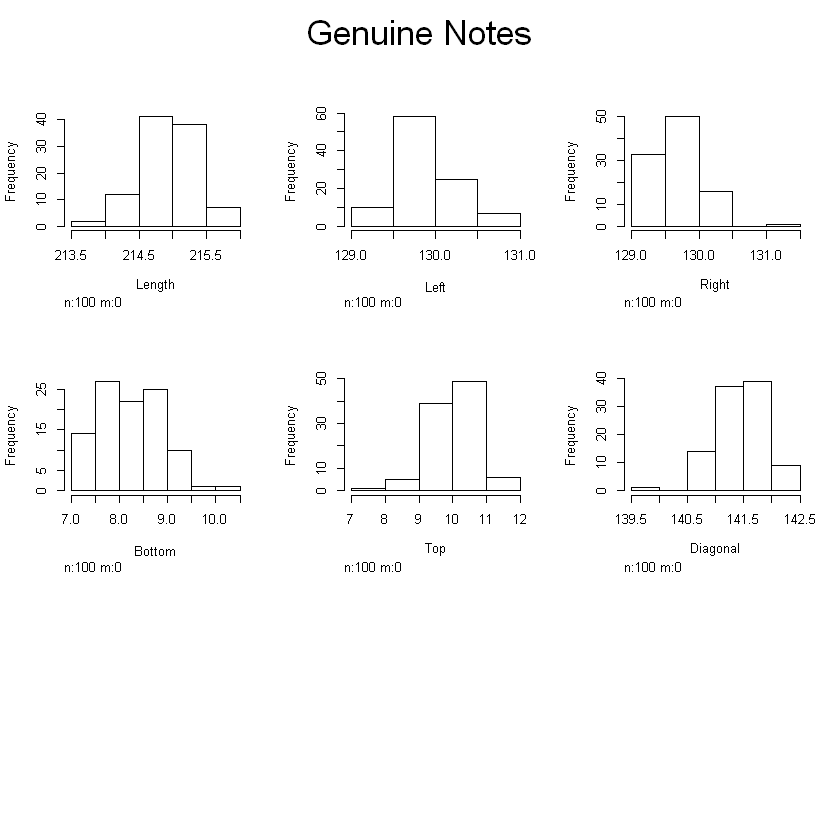

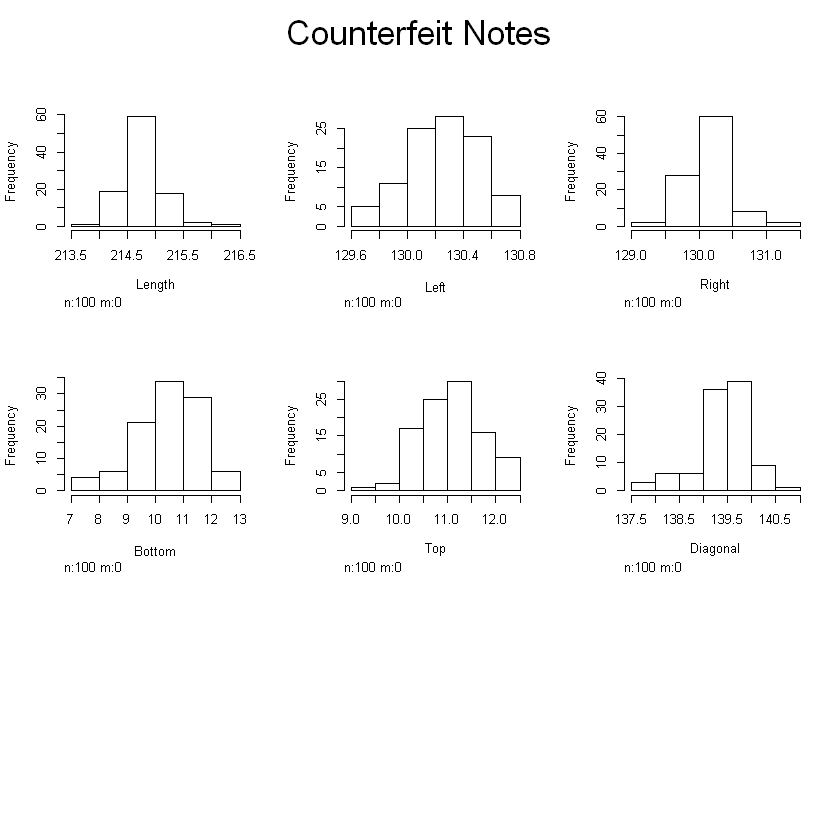

In [6]:
par(mfrow=c(3,3))
hist.data.frame(notes, mtitl = 'Overall Distributions')
hist.data.frame(genuine, mtitl= 'Genuine Notes')
hist.data.frame(counterfeit,mtitl = 'Counterfeit Notes')

In the entire dataset, the first three distributions look fairly normal in the  while the last three seem right-skewed, left-skewed, and bimodal. We can see that some measurements, like Bottom and Top, vary signficantly between the two groups. Within the groups, the distributions all generally seem normal or somewhat skewed.

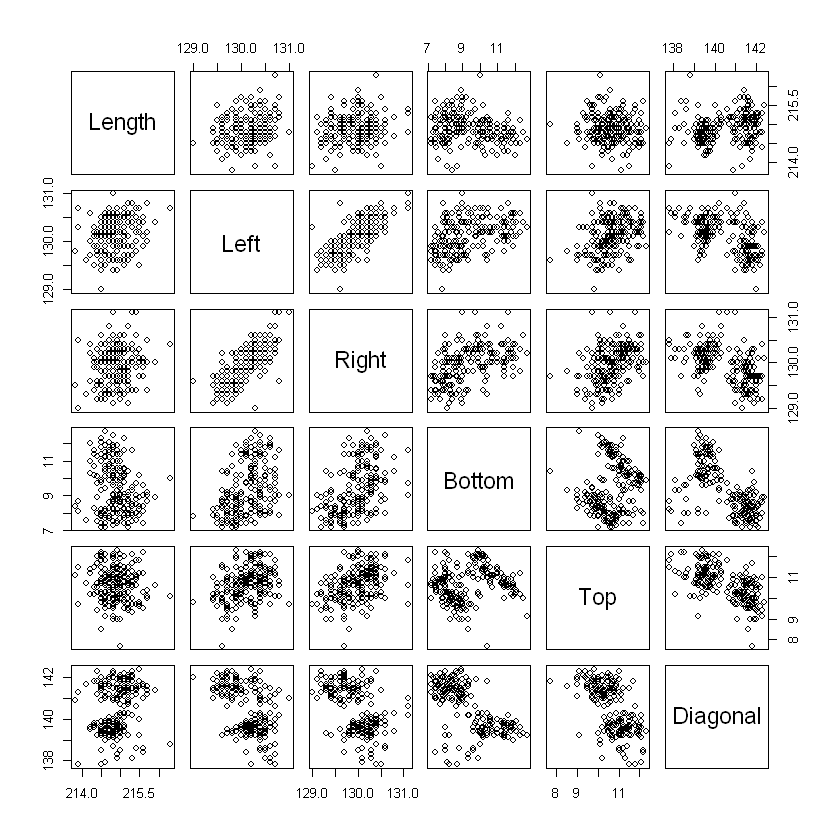

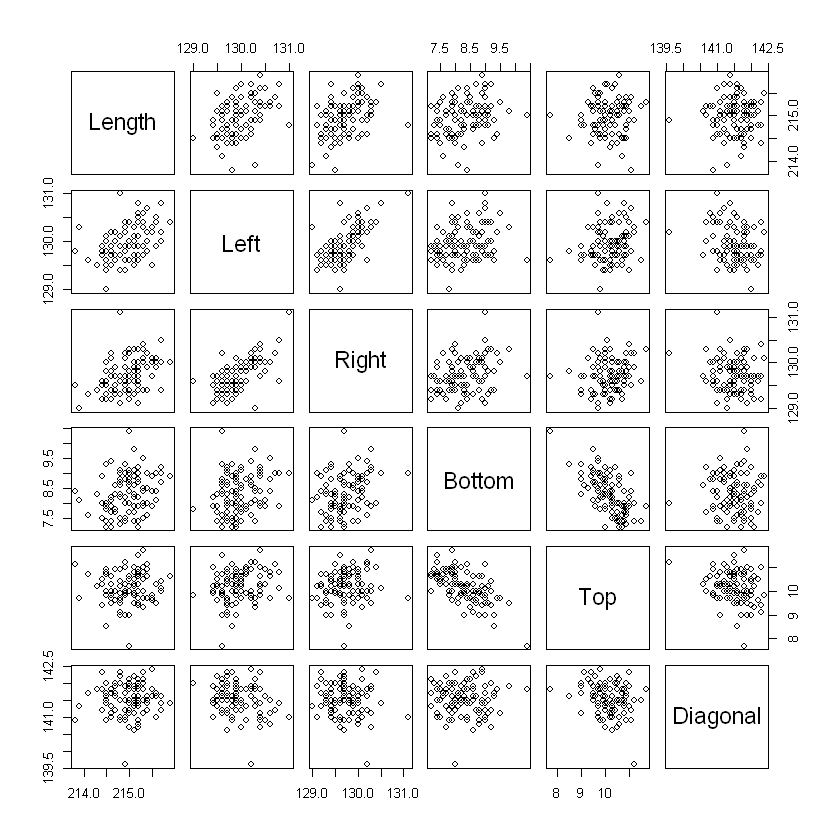

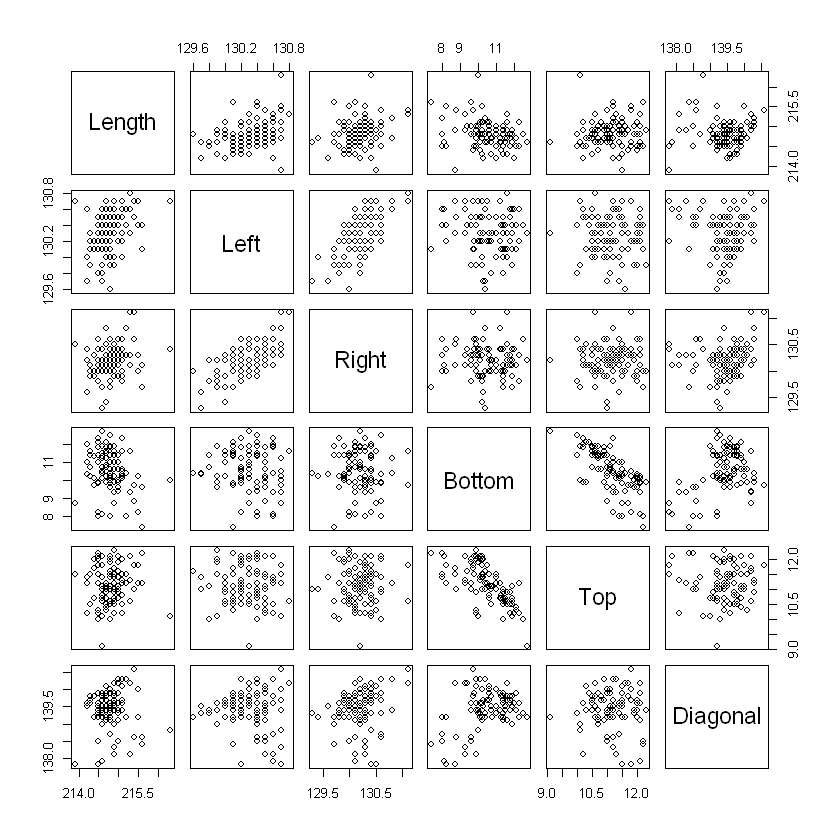

In [7]:
par(mfrow=c(1,3))
pairs(notes)
pairs(genuine)
pairs(counterfeit)

In [27]:
genuine['genuine'] = 'genuine'

In [28]:
counterfeit['genuine'] = 'counterfeit'

In [29]:
labeled = rbind(genuine,counterfeit)
head(labeled)

,Length,Left,Right,Bottom,Top,Diagonal,genuine
BN1,214.8,131.0,131.1,9.0,9.7,141.0,genuine
BN2,214.6,129.7,129.7,8.1,9.5,141.7,genuine
BN3,214.8,129.7,129.7,8.7,9.6,142.2,genuine
BN4,214.8,129.7,129.6,7.5,10.4,142.0,genuine
BN5,215.0,129.6,129.7,10.4,7.7,141.8,genuine
BN6,215.7,130.8,130.5,9.0,10.1,141.4,genuine


We will use $k=10$ for $k$-fold CV. Note that we set the seed to `123`, this is so the CV splits will be the same across models.

### Linear Discriminant Analysis

We have two groups in the training data, $k = genuine (g), counterfeit(c)$.

We classify an observation $x$ as genuine:

$d^L_g (\underline{x}) - d^L_c (\underline{x}) > 0$

and can write this as a linear function:

$d^L_g (\underline{x}) - d^L_c (\underline{x}) = - \frac{1}{2} \underline{\mu}_g^{\prime} {\mathbf \Sigma}^{-1} \underline{\mu}_g + \frac{1}{2} \underline{\mu}_c^{\prime} {\mathbf \Sigma}^{-1} \underline{\mu}_c + \log (p_g /p_c) + {( \underline{\mu}_g - \underline{\mu}_c )}^{\prime} {\mathbf \Sigma}^{-1} \underline{x}.$

Let $c = \frac{1}{2} \left( \underline{\mu}_g^{\prime} {\mathbf \Sigma}^{-1} \underline{\mu}_g - \underline{\mu}_c^{\prime} {\mathbf \Sigma}^{-1} \underline{\mu}_c \right) - \log (p_g /p_c)$ and $\underline{\omega} = {\mathbf \Sigma}^{-1} {( \underline{\mu}_g - \underline{\mu}_c )}$.

Then $\underline{\omega}^{\prime} \underline{x} > c.$

So, we classify as genuine if $\underline{\omega}^{\prime} \underline{x} > c$ and counterfeit if $\underline{\omega}^{\prime} \underline{x} < c$. Namely, $\underline{\omega} = {\mathbf \Sigma}^{-1} {( \underline{\mu}_g - \underline{\mu}_c )}$  makes the two groups most separable.

In [251]:
train.control = trainControl(method = "cv", number = 10)

In [82]:
lda <- train(notes, as.factor(labeled$'genuine'), method = "lda",
               trControl = train.control)

In [83]:
lda$resample

Accuracy,Kappa,Resample
1.00,1.0,Fold01
1.00,1.0,Fold02
1.00,1.0,Fold03
1.00,1.0,Fold04
1.00,1.0,Fold05
1.00,1.0,Fold06
1.00,1.0,Fold07
0.95,0.9,Fold08
1.00,1.0,Fold09
1.00,1.0,Fold10


Our model is very accurate, with perfect accuracy on all but one fold (8).

### Logistic Regression

We wish to predict a binary response using multiple predictors.
- We generalize regular logistic regession as follows:
$
 \log \left( \frac{ p( \underline{X})}{ 1- p (\underline{X})} \right)
 = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p
$
where is $\underline{X}$ is a $p$-vector of covariates.
- Thus
$
 p( \underline{X}) = \frac{ \exp \{  \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p \} }{
  1 + \exp \{  \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p \} }
$
- Let $\underline{\beta} = {[ \beta_1, \ldots, \beta_p ]}^{\prime}$ be the coefficients; $\beta_0$ is the intercept.

### Logistic Function

$
 \phi (t) = \frac{1}{1 + e^{-t}}
$
- The model for ${(Y,\underline{X})}$ is
$
 p( \underline{x}) = {\mathbb P} [ Y = 1 \vert \underline{X} = \underline{x} ] 
  = \phi ( \beta_0 + \underline{x}^{\prime} \underline{\beta})
$
- Or
$
 {\mathbb P} [ Y = 0 \vert \underline{X} = \underline{x} ] 
  = 1 - \phi ( \beta_0 + \underline{x}^{\prime} \underline{\beta})
$
 

### Likelihood Function

- We assume that $(Y_1, \underline{X}_1),\ldots,(Y_n,\underline{X}_n)$ are i.i.d. 
- Conditional density $Y_i$ given $\underline{X}_i$ is
$
  { \left( \phi ( \beta_0 + \underline{X}_i^{\prime} \underline{\beta} ) \right)}^{Y_i}
  \,  { \left( 1 - \phi ( \beta_0 + \underline{X}_i^{\prime} 
  \underline{\beta} ) \right)}^{1 - Y_i}
$
Joint density of $Y_1, \ldots, Y_n$ given $\underline{X}_1, \ldots,\underline{X}_n$ is
$
 L_n (\beta_0, \underline{\beta} ) = \prod_{i=1}^n  { \left( \phi ( \beta_0 + \underline{X}_i^{\prime} \underline{\beta} ) \right)}^{Y_i}
  \,  { \left( 1 - \phi ( \beta_0 + \underline{X}_i^{\prime} 
  \underline{\beta} ) \right)}^{1 - Y_i}
$
$L_n: {\mathbb R}^{p+1} \rightarrow [0,\infty)$: *likelihood function*.

### Maximum Likelihood Estimator

- $(\widehat{\beta}_0, \widehat{\underline{\beta}})$
defined as the maximizer of the likelihood function:
$
(\widehat{\beta}_0, \widehat{\underline{\beta}}) = \arg \max 
L_n (\beta_0, \underline{\beta} ) 
$
- We utilize the logarithm of the likelihood function for ease of use.
$
 \mathcal{L}_n (\beta_0, \underline{\beta} ) = \log L_n (\beta_0, \underline{\beta} )
 =   \sum_{i=1}^n \left\{ Y_i \, \log \left( \phi ( \beta_0 + \underline{X}_i^{\prime} \underline{\beta} ) \right) +  (1 - Y_i) \log \left( 1 - \phi ( \beta_0 + \underline{X}_i^{\prime}   \underline{\beta} ) \right) \right\}
$

In [ ]:
logistic <- train(notes, as.factor(labeled$'genuine'), method = "glm",
               family="binomial",maxit=100, trControl = train.control)

In [86]:
logistic$resample

Accuracy,Kappa,Resample
1.00,1.0,Fold01
0.95,0.9,Fold02
1.00,1.0,Fold03
1.00,1.0,Fold04
1.00,1.0,Fold05
0.95,0.9,Fold06
1.00,1.0,Fold07
1.00,1.0,Fold08
0.95,0.9,Fold09
1.00,1.0,Fold10


Our logistic model is also very accurate, but less so than the LDA model. It has worse performance on folds 2, 6, and 9. However, it does manange to be more accurate than LDA on Fold 8.

### Factor Analysis

We have a $p$-dimensional random variable 
$
\underline{x} = {[ x_1, \ldots, x_p]}^{\prime},
$
with population mean vector ${\mathbf E} [ \underline{x}] = \underline{\mu}$.
- Consider $m$ unobservable common factors 
$
\underline{f} = {[ f_1, \ldots, f_m]}^{\prime},
$
where $f_j$ denotes the $j$th common factor ($j = 1, \ldots, m$).
- Generally, $m$ is substantially smaller than $p$.

### Model

- A series of multiple linear regressions, predicting each of the observable variables $x_j$ from the values of the unobservable common factors $\underline{f}$:
\begin{align*}
 x_1 & = \mu_1 + \ell_{11} f_1 + \ell_{12} f_2 + \ldots + \ell_{1m} f_m + \epsilon_1 \\
 x_2 & = \mu_2 + \ell_{21} f_1 + \ell_{22} f_2 + \ldots + \ell_{2m} f_m + \epsilon_2 \\
  & \vdots \\
 x_p & = \mu_p + \ell_{p1} f_1 + \ell_{p2} f_2 + \ldots + \ell_{pm} f_m + \epsilon_p. \\
\end{align*}
- $\underline{x}$ is the only observable data in a factor model.


### Factor Loadings and Error Vector

- The regression coefficient $\ell_{jk}$ is called the loading of the $j$th variable on $k$th factor.
- Collecting the regression coefficients for all the multiple regressions yields a matrix of factor loadings.


- ${\mathbf L}$ is called the *factor loading matrix*.

- The factor model can be summarized in a relatively simple matrix format:
$
  \underline{x}= \underline{\mu} + {\mathbf L} \, \underline{f} + \underline{\epsilon}.
$

 
### Flexibility in Factor Model

- The factor model is a very flexible model, as it holds for any $\underline{\mu}$, ${\mathbf L}$, $\underline{f}$, and $\underline{\epsilon}$ that satisfy the linear form
$\underline{x}= \underline{\mu} + {\mathbf L} \, \underline{f} + \underline{\epsilon}.$
- However, $\underline{\mu}$, ${\mathbf L}$, $\underline{f}$, and $\underline{\epsilon}$ 
are all unobservable to us. This will cause some issues, as the choice of these components are not unique.
- Mean vector:
$\begin{align*}
  {\mathbb E}  [ \underline{x}] & = \underline{\mu} + 
  {\mathbf L} \,  {\mathbb E} [\underline{f}] +  {\mathbb E} [\underline{\epsilon}] \\
  & = \left( \underline{\mu} + {\mathbf L} \, \underline{\delta} \right)  +
  {\mathbf L} \,  {\mathbb E} [\underline{f} - \underline{\delta}] 
  +  {\mathbb E} [\underline{\epsilon}] 
\end{align*}  $
- Variance-covariance matrix: if $\underline{f}$ and $\underline{\epsilon}$ are uncorrelated with each other,
$\begin{align*}
  \mbox{Cov}   [ \underline{x}] & =  
  {\mathbf L} \, \mbox{Cov} [\underline{f}] \,  {\mathbf L}^{\prime} 
   +   \mbox{Cov}   [\underline{\epsilon}] \\
   & =   \left( c {\mathbf L} \right) \, \mbox{Cov} [\underline{f}/c] \,  
    { \left( c {\mathbf L} \right) }^{\prime}    +   \mbox{Cov}   [\underline{\epsilon}]
\end{align*}$


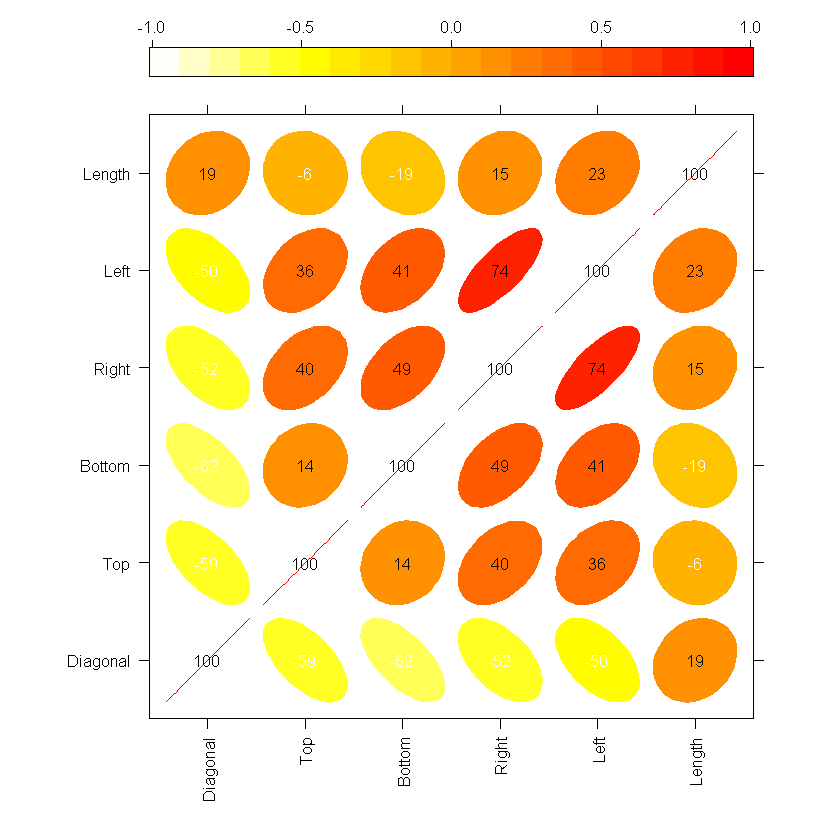

In [88]:
cor_df <- cor(notes)

# Function to generate correlation plot
panel.corrgram <- function(x, y, z, subscripts, at, level = 0.9, label = FALSE, ...) {
     require("ellipse", quietly = TRUE)
     x <- as.numeric(x)[subscripts]
     y <- as.numeric(y)[subscripts]
     z <- as.numeric(z)[subscripts]
     zcol <- level.colors(z, at = at,  ...)
     for (i in seq(along = z)) {
         ell=ellipse(z[i], level = level, npoints = 50, 
                     scale = c(.2, .2), centre = c(x[i], y[i]))
         panel.polygon(ell, col = zcol[i], border = zcol[i], ...)
     }
     if (label)
         panel.text(x = x, y = y, lab = 100 * round(z, 2), cex = 0.8,
                    col = ifelse(z < 0, "white", "black"))
 }

# generate correlation plot
print(levelplot(cor_df[seq(6,1), seq(6,1)], at = do.breaks(c(-1.01, 1.01), 20),
           xlab = NULL, ylab = NULL, colorkey = list(space = "top"), col.regions=rev(heat.colors(100)),
           scales = list(x = list(rot = 90)),
           panel = panel.corrgram, label = TRUE))

We can see that measurements such as left and right seem to be highly correlated. Perhaps these can be represented in one factor.

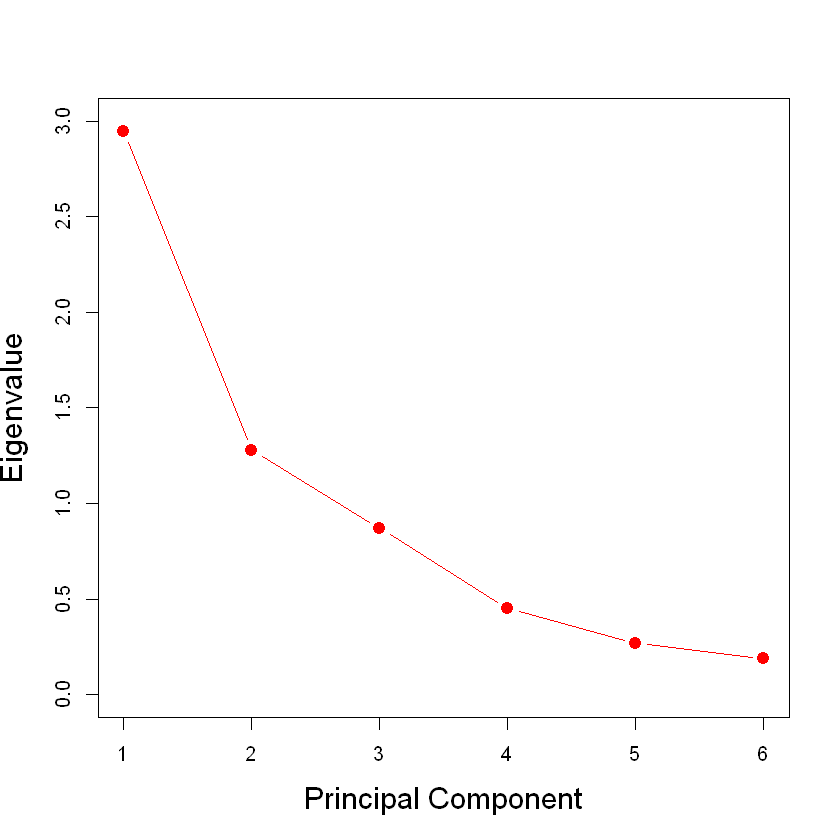

In [89]:
# Generate scree plot
pca_result <- prcomp (notes, scale =TRUE)
eigen_val <- pca_result$sdev^2
pve <- eigen_val/sum(eigen_val)

plot(eigen_val  , xlab=" Principal Component ", ylab=" Eigenvalue ", 
     ylim=c(0,3), xaxt="n" ,type='b', col="red", cex=2,
pch=20, cex.lab=1.5)
axis(1, at=c(1,2,3,4,5,6),labels=c(1,2,3,4,5,6))

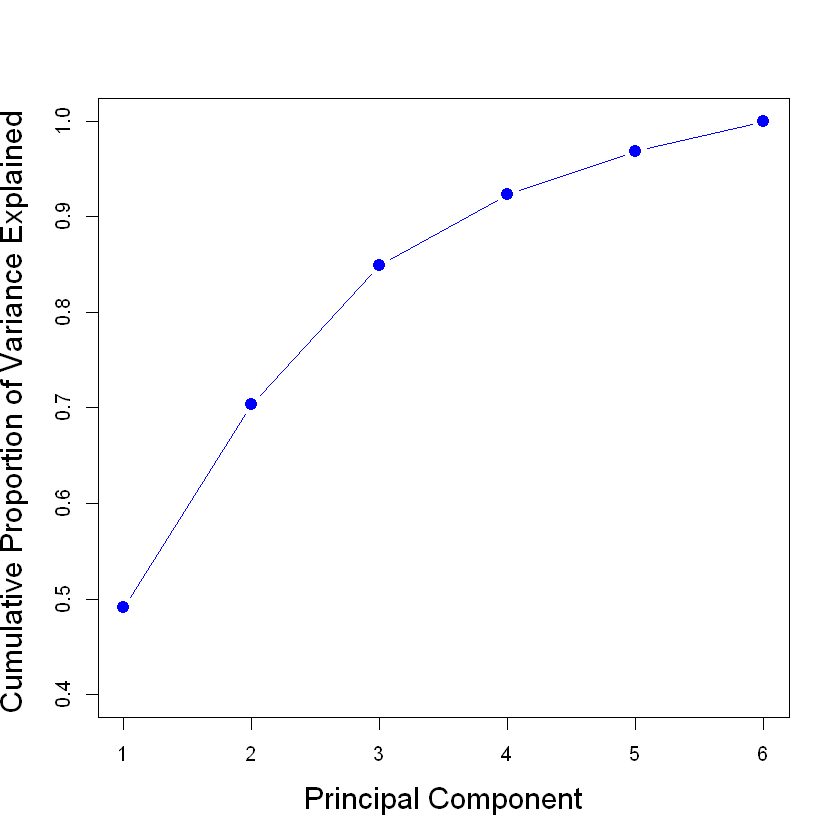

In [90]:
# Cumulative Proportion plot
plot(cumsum(pve), xlab=" Principal Component ", 
  ylab ="Cumulative Proportion of Variance Explained ", 
  ylim=c(0.4,1) , xaxt="n",type='b', col="blue", cex=2, pch=20, cex.lab=1.5)
axis(1, at=c(1,2,3,4,5,6),labels=c(1,2,3,4,5,6))

$m=3$ seems like a good choice here as almost 90% of the cumulative variance is explained and we still see our dimensionality reduced in half.

In [91]:
# Set the number of factors as 3
n.factors <- 3

# Fit factor model (in base R)
# The n.factors denotes how many factors used in fitting
# The scores option denotes how the factor scores are calcualted
# The rotation option denotes what rotation matrix is used
fa_fit <- factanal(notes, n.factors, rotation="varimax")

# Factor loadings
loading <- fa_fit$loadings[,1:3]
t(loading)

,Length,Left,Right,Bottom,Top,Diagonal
Factor1,-0.1798542,0.3509698,0.4266324,0.98730708,0.03239197,-0.523363912
Factor2,-0.1316173,0.4103754,0.4058786,0.14161289,0.76908314,-0.749832691
Factor3,0.4840111,0.7096473,0.6014242,0.01307913,0.07635236,-0.004236968


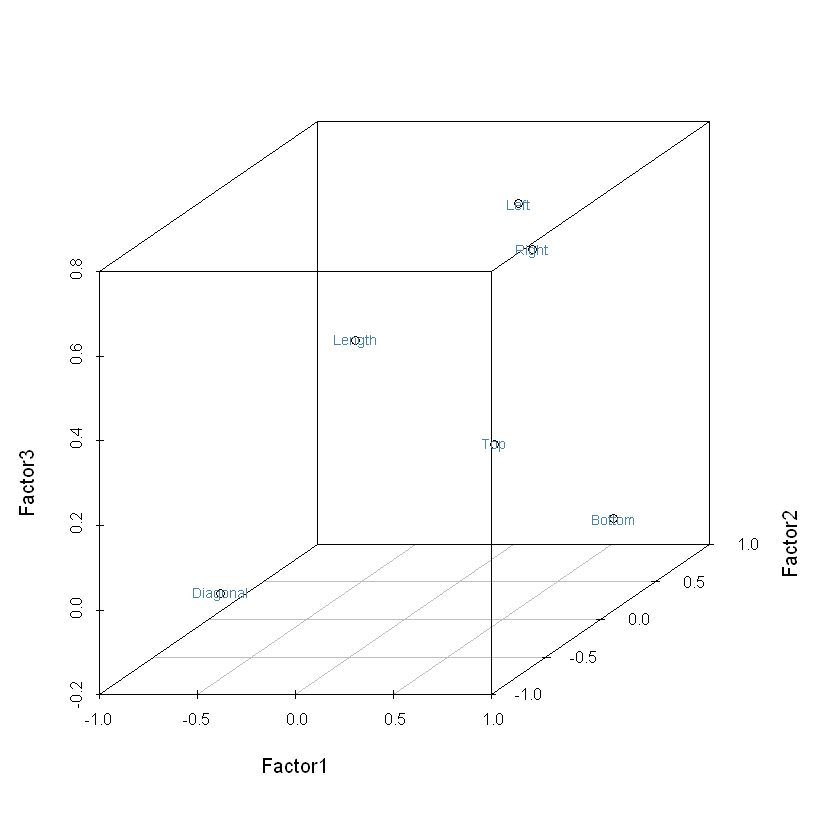

In [107]:
scatterplot3d(loading) # set up plot
text(scatterplot3d(loading)$xyz.convert(loading), labels = names(notes),
    cex= 0.7, col = "steelblue")

Factor 1 is mainly loaded on Left, Right, and Bottom. 2 involves Top, Left, and Right, while 3 is Left and Right.

In [217]:
projected = data.frame(apply(notes, 1, function(x) dot(x, loading[1:6])))
projected = cbind(projected, data.frame(apply(notes, 1, function(x) dot(x, loading[7:12]))))
projected = cbind(projected, data.frame(apply(notes, 1, function(x) dot(x, loading[13:18]))))
colnames(projected) = colnames(loading)

In [218]:
head(projected)

,Factor1,Factor2,Factor3
BN1,-1.318471,-18.29334,276.0370
BN2,-3.597455,-20.17488,274.1457
BN3,-3.299485,-20.41425,274.2558
BN4,-4.396330,-19.85954,274.2419
BN5,-1.544330,-21.40219,274.1605
BN6,-2.002902,-18.72969,275.9987


In [219]:
factor_lda <- train(projected, as.factor(labeled$'genuine'), method = "lda",
               trControl = train.control)

In [249]:
factor_lda$resample

Accuracy,Kappa,Resample
1.00,1.0,Fold01
1.00,1.0,Fold02
1.00,1.0,Fold03
1.00,1.0,Fold04
1.00,1.0,Fold05
1.00,1.0,Fold06
0.95,0.9,Fold07
1.00,1.0,Fold08
1.00,1.0,Fold09
1.00,1.0,Fold10


We have identical performance to our original LDA model, albeit with a different fold having 95% accuracy.

In [ ]:
factor_logistic <- train(projected, as.factor(labeled$'genuine'), method = "glm",
               family="binomial",maxit=100, trControl = train.control)

In [224]:
factor_logistic$resample

Accuracy,Kappa,Resample
1.00,1.0,Fold01
0.95,0.9,Fold02
1.00,1.0,Fold03
1.00,1.0,Fold04
1.00,1.0,Fold05
1.00,1.0,Fold06
1.00,1.0,Fold07
1.00,1.0,Fold08
1.00,1.0,Fold09
1.00,1.0,Fold10


Our new logistic model is markedly improved and is now on par with our LDA models.

## Model Assumptions

- We make the following model assumptions for factor analysis. 
- Assumptions on mean vector:

1. The common factors all have mean zero:
$
 {\mathbb E} [ \underline{f} ] = 0.
$

2. The specific factors (or random errors) all have mean zero:
$
 {\mathbb E} [ \underline{\epsilon} ] = 0.
$

We will assume these hold true for the purpose of performing factor analysis as the mean must neccessarily be zero, as subtracting from the factors would produce an invalid result since the mean would no longer be zero.

- Assumptions on variance-covariance matrix:

1. Common factors satisfy:
$
 \mbox{Cov} [ \underline{f} ] = I_m,
 $
 where $I_m$ is an $m \times m$-dimensional identity matrix.
 
 We assume this holds as a fixed covariance matrix makes re-scaling impossible.
 
2. Random errors satisfy:
$
 \mbox{Cov} [ \underline{\epsilon} ] = {\mathbf \Psi} = \mbox{diag} (\psi_1, \ldots, \psi_p).
 $
 
 This follows if $\epsilon$'s covariance matrix is diagonal, then the off-diagonal entries (the cross covariances) are zero. Then there are no correlations.
 
3. Common factors and random errors are uncorrelated:
$
 \mbox{Cov} [ \underline{f}, \underline{\epsilon} ] = 0.
 $
 
 This follows from the prior explanation.
 
- With the assumptions imposed on the mean vector, we can avoid the flexibility issue of the
mean vector. The mean vector is now fully explained by the intercept:
$
  {\mathbb E}  [ \underline{x}]  = \underline{\mu} + 
  {\mathbf L} \,  {\mathbb E} [\underline{f}] +  {\mathbb E} [\underline{\epsilon}] 
  = \underline{\mu}.
$
- With the assumptions imposed on the variance-covariance matrix, we can avoid the flexibility issue of ${\mathbf \Sigma}$:
$
 \mbox{Cov} [ \underline{x}] = 
 {\mathbf L} \, \mbox{Cov} [\underline{f}] \,  {\mathbf L}^{\prime} 
   +   \mbox{Cov}   [\underline{\epsilon}] = 
   {\mathbf L} \,  {\mathbf L}^{\prime}    +  {\mathbf \Psi}.
$
 This is the matrix of factor loadings times its transpose, plus a diagonal matrix containing the specific variances.

The factor analysis was overall beneficial as we were able to maintain the same accuracy in our LDA classifier with half the features. In the case of the logistic classifier, we actually improved our accuracy from .985 to .995 with the factor model.

In [84]:
print(lda)

Linear Discriminant Analysis 

200 samples
  6 predictor
  2 classes: 'counterfeit', 'genuine' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 180, 180, 180, 180, 180, 180, ... 
Resampling results:

  Accuracy  Kappa
  0.995     0.99 



In [87]:
print(logistic)

Generalized Linear Model 

200 samples
  6 predictor
  2 classes: 'counterfeit', 'genuine' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 180, 180, 180, 180, 180, 180, ... 
Resampling results:

  Accuracy  Kappa
  0.985     0.97 



In [221]:
print(factor_lda)

Linear Discriminant Analysis 

200 samples
  3 predictor
  2 classes: 'counterfeit', 'genuine' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 180, 180, 180, 180, 180, 180, ... 
Resampling results:

  Accuracy  Kappa
  0.995     0.99 



In [225]:
print(factor_logistic)

Generalized Linear Model 

200 samples
  3 predictor
  2 classes: 'counterfeit', 'genuine' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 180, 180, 180, 180, 180, 180, ... 
Resampling results:

  Accuracy  Kappa
  0.995     0.99 



## Conclusion

The LDA model is the best with no dimension reduction, with overall 99.5% accuracy. The logistic model falters on some folds (previously mentioned) and so has a lower 98.5% accuracy. With factor analysis, however, we reduced our dimensions in half to 3 and this actually increased the logistic model's accuracy to be on par with LDA. We saw that there was a significant difference in the counterfeit and genuine bills as all of our classifiers had very high accuracy. However, the effecctiveness of the model may be limited due to our small dataset. The factor analysis proved beneficial as it made our model less complex. Overall, the LDA and both models with factor analysis were the best, while the regular logistic model was slightly worse.